In [64]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score

#BEFORE DOING ANY CODING, MAKE SURE TO CLEAN DATA
- missing data
- categorical v/s numerical
-

In [65]:
ames = pd.read_csv("https://www.dropbox.com/scl/fi/g0n5le5p6fr136ggetfsf/AmesHousing.csv?rlkey=jlr9xtz1o6u5rghfo29a5c02f&dl=1")

In [66]:
# Get rid of columns with mostly NaN values
good_cols = ames.isna().sum() < 100 #where do i have less than 100 observations
ames = ames.loc[:,good_cols]
#keep columns with enough data

# Drop other NAs
ames = ames.dropna()

# Linear Regression

In [67]:
X = ames.drop(["SalePrice", "Order", "PID"], axis = 1)
#dropped Order and PID, why? --> because we'll never use it
#these were ID columns, provides no info. never want to include ID columns
y = ames["SalePrice"]


ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown = "ignore"),
    make_column_selector(dtype_include=object)), #selecting all columns that are categorical
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number)) #standardizing numerical variables
  ],
  remainder = "passthrough" #keep everything else
)

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

In [68]:
scores = cross_val_score(lr_pipeline_1, X, y, cv=5, scoring='r2')
scores

array([-4.59217770e+20, -1.21723181e+20, -8.37868327e+19, -9.71584476e+20,
       -3.78389822e+20])

In [69]:
lr_pipeline_1_fitted = lr_pipeline_1.fit(X, y)

In [70]:
coeff_1 = lr_pipeline_1_fitted.named_steps['linear_regression'].coef_

handle_unknown = "ignore"
with each model specification, X_train and X_test are random. some categories are rly small so they end up in either training or testing only. let's say its only in x_train. when u do x_test, there's no this specific small category so its like huh what is this small category variable i don't recognize. so u do handle_unknown = ignore to do nothing and move on.

In [71]:
cross_val_score(lr_pipeline_1, X, y, cv = 5, scoring = 'r2')

array([-4.59217770e+20, -1.21723181e+20, -8.37868327e+19, -9.71584476e+20,
       -3.78389822e+20])

we are overfitting here, too many predictor variables
- betas are way too large

# Regularization - add new piece to our loss function that restricts flexibility of betas

when beta plugged in, want this equation to be as small as possible


# Ridge Regression

In [72]:
#practice activity
X = ames.drop(["SalePrice", "Order", "PID"], axis = 1)
y = ames["SalePrice"]


ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_2 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge())]
)

In [73]:
scores = cross_val_score(lr_pipeline_2, X, y, cv=5, scoring='r2')
scores

array([0.8983804 , 0.91749817, 0.79251623, 0.78248152, 0.91492025])

In [74]:
#fit model on whole dataset
lr_pipeline_2_fitted = lr_pipeline_2.fit(X, y)

In [75]:
#get coefficients
coeff_2 = lr_pipeline_2_fitted.named_steps['ridge_regression'].coef_

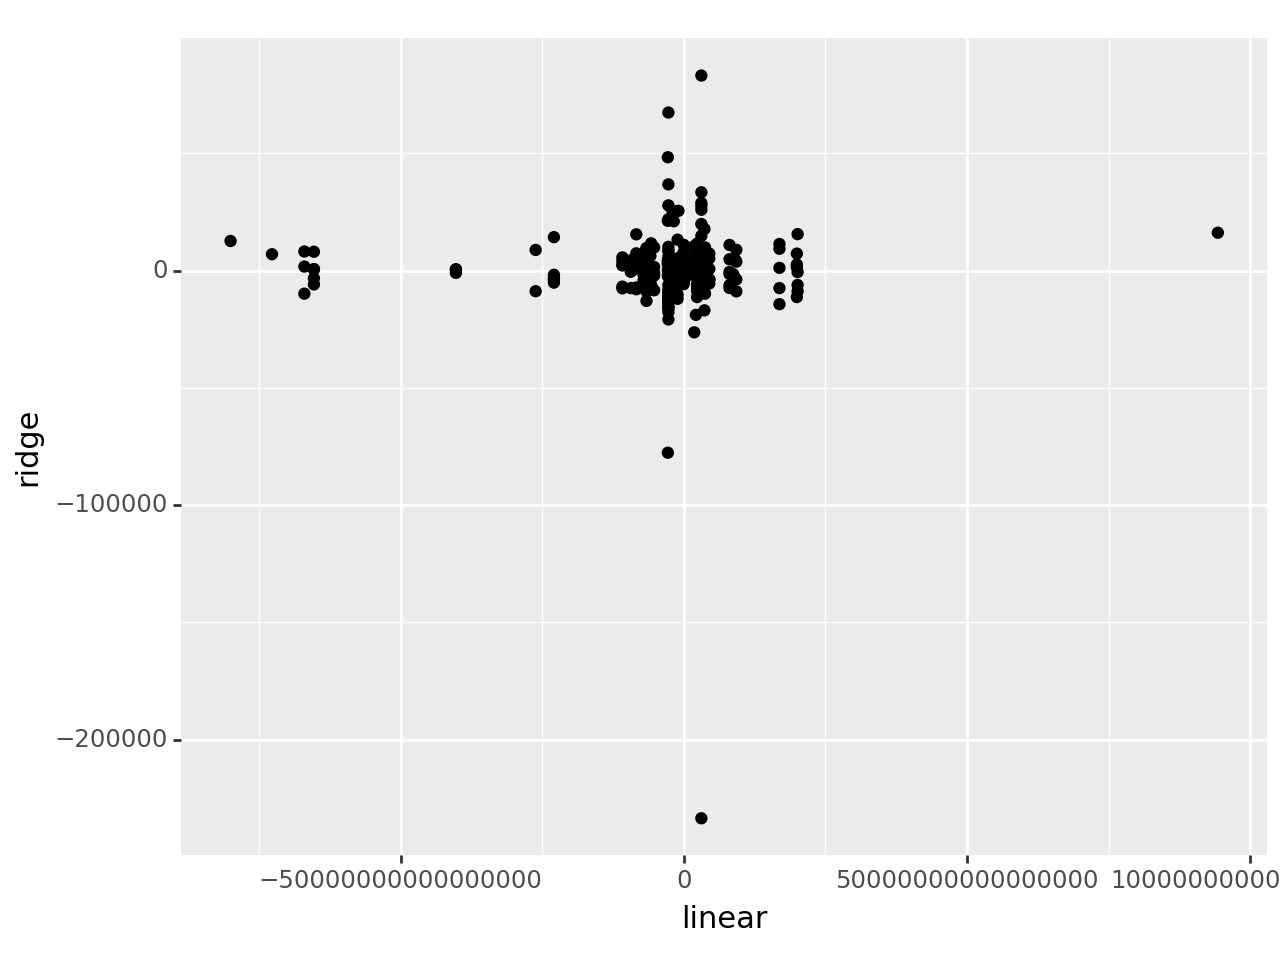

<Figure Size: (640 x 480)>

In [76]:
#plot with coefficients
df_coeff = pd.DataFrame({"linear": coeff_1,
                         "ridge": coeff_2})
df_coeff

from plotnine import *
(ggplot(df_coeff, aes(x = "linear", y = "ridge"))
+ geom_point())

In [77]:
#tuning with different numbers of alpha
list_alpha = [0.001, 0.01, 0.1, 1, 10]
alphas = {'ridge_regression__alpha': list_alpha}

#running girdsearchcv
from sklearn.model_selection import GridSearchCV
gscv = GridSearchCV(lr_pipeline_2, alphas, cv = 5, scoring='r2')


In [78]:
#tuning
gscv_fitted = gscv.fit(X, y)

pd.DataFrame(gscv_fitted.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge_regression__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.104349,0.027887,0.035807,0.011334,0.001,{'ridge_regression__alpha': 0.001},0.898542,0.909602,0.786947,0.768704,0.900932,0.852945,0.061716,5
1,0.163112,0.020425,0.066496,0.014852,0.01,{'ridge_regression__alpha': 0.01},0.898577,0.909837,0.787055,0.769120,0.901529,0.853224,0.061720,4
2,0.163044,0.004282,0.066487,0.017111,0.1,{'ridge_regression__alpha': 0.1},0.898777,0.911740,0.788015,0.772490,0.906094,0.855423,0.061710,3
3,0.152824,0.021216,0.059675,0.024931,1,{'ridge_regression__alpha': 1},0.898380,0.917498,0.792516,0.782482,0.914920,0.861159,0.060583,2
4,0.099212,0.012807,0.034158,0.011348,10,{'ridge_regression__alpha': 10},0.897251,0.921362,0.797511,0.784667,0.915983,0.863355,0.059683,1


In [30]:
gscv_fitted.cv_results_['mean_test_score']

array([0.85294546, 0.85322362, 0.85542319, 0.86115931, 0.86335485])

In [115]:
pd.DataFrame(data = {"alpha": gscv_fitted.cv_results_['param_ridge_regression__alpha'], "scores": gscv_fitted.cv_results_['mean_test_score']}).sort_values(by = "scores", ascending = False)

,alpha,scores
4,10,0.863355
3,1,0.861159
2,0.1,0.855423
1,0.01,0.853224
0,0.001,0.852945


The best model in the regression pipeline is when the alpha value is 10. The R^2 vale is 0.863355.

# Lasso
- this will choose the best predictor variables for you
- automatic feature selection: predictors whose coefficients become zero are the ones that are not needed to get better predictive power

In [81]:
#lasso pipeline

X = ames.drop(["SalePrice", "Order", "PID"], axis = 1)
y = ames["SalePrice"]


ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_3 = Pipeline(
  [("preprocessing", ct),
  ("lasso", Lasso())]
)

In [82]:
#cross validation
scores = cross_val_score(lr_pipeline_3, X, y, cv=5, scoring='r2')
scores

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.688e+10, tolerance: 1.474e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.393e+10, tolerance: 1.463e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.582e+10, tolerance: 1.477e+09


array([0.89890206, 0.91021274, 0.79352217, 0.7703388 , 0.90647455])

In [83]:
lr_pipeline_3_fitted = lr_pipeline_3.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.980e+10, tolerance: 1.793e+09


In [ ]:
#getting coefficients
coeff_3 = lr_pipeline_3_fitted.named_steps['lasso'].coef_
coeff_3 #you will see some coefficients as 0

In [85]:
list_alpha = [0.001, 0.01, 0.1, 1, 10]
alphas = {'lasso__alpha': list_alpha}
gscv3 = GridSearchCV(lr_pipeline_3, alphas, cv = 5, scoring='r2')


In [ ]:
gscv_fitted3 = gscv3.fit(X, y)

gscv_fitted3.cv_results_

In [87]:
gscv_fitted3.cv_results_['mean_test_score']

array([0.8544398 , 0.85454916, 0.85539429, 0.85589007, 0.85949508])

In [114]:
ridge_df = pd.DataFrame(data = {"alpha": gscv_fitted.cv_results_['param_ridge_regression__alpha'],
                     "scores_ridge": gscv_fitted.cv_results_['mean_test_score'],
                     "scores_lasso": gscv_fitted3.cv_results_["mean_test_score"]})
ridge_df.sort_values(by = "scores_lasso", ascending = False)

,alpha,scores_ridge,scores_lasso
4,10,0.863355,0.859495
3,1,0.861159,0.855890
2,0.1,0.855423,0.855394
1,0.01,0.853224,0.854549
0,0.001,0.852945,0.854440


The best model using the lasso regression model is when the alpha value is 10. The R^2 is 0.859495.

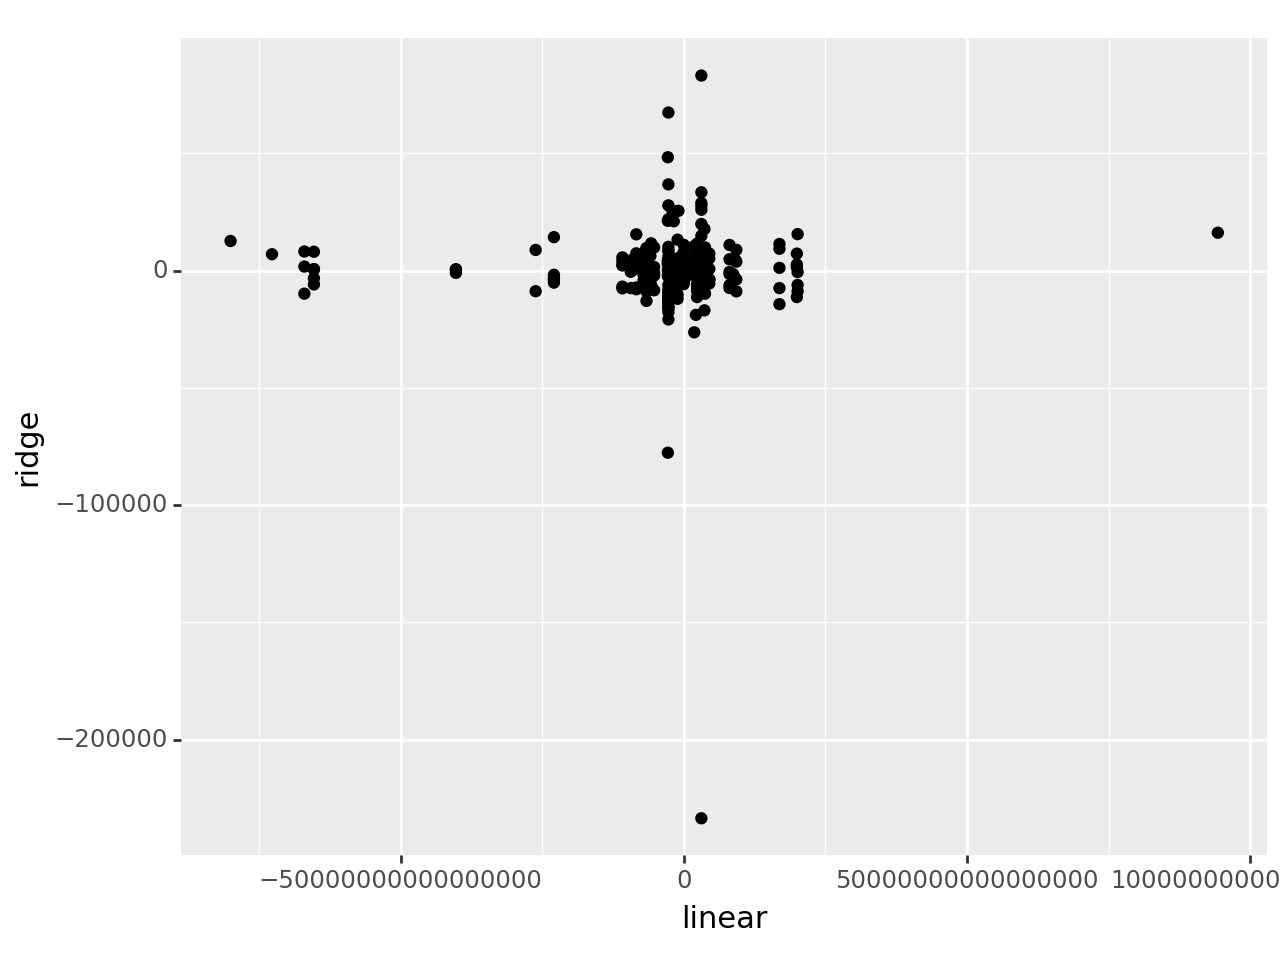

<Figure Size: (640 x 480)>

In [113]:
#compare the coefficients to ridge and OLS
df_coeff["lasso"] = coeff_3
df_coeff

#create plot comparing coefficients to lasso and ols
(ggplot(df_coeff, aes(x = "linear", y = "ridge")) + geom_point())

#Elastic Net: combo of LASSO and Ridge
- there is a lambda and alpha, make sure to specify both in the dictionary for tuning

In [90]:
#elastic net

X = ames.drop(["SalePrice", "Order", "PID"], axis = 1)
y = ames["SalePrice"]


ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_4 = Pipeline(
  [("preprocessing", ct),
  ("elastic_net", ElasticNet())]
)

In [91]:
#cross validation
scores = cross_val_score(lr_pipeline_4, X, y, cv=5, scoring='r2')
scores

array([0.84881153, 0.89544437, 0.78218137, 0.74552196, 0.88112237])

In [ ]:
lr_pipeline_4_fitted = lr_pipeline_4.fit(X, y)

#coefficients
coeff_4 = lr_pipeline_4_fitted.named_steps['elastic_net'].coef_
coeff_4

In [107]:
#tuning

values = {'elastic_net__alpha': list_alpha,
          "elastic_net__l1_ratio": list_alpha} #creating dictionary of values to try out

gscv4 = GridSearchCV(lr_pipeline_4, values, cv = 5, scoring='r2')

gscv_fitted4 = gscv4.fit(X, y)

elastic_df = pd.DataFrame(gscv_fitted4.cv_results_)
elastic_df

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.497e+11, tolerance: 1.348e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.277e+11, tolerance: 1.474e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.083e+11, tolerance: 1.463e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.p

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_elastic_net__alpha,param_elastic_net__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.833859,0.063524,0.031511,0.002369,0.001,0.001,"{'elastic_net__alpha': 0.001, 'elastic_net__l1...",0.898103,0.919031,0.794712,0.784848,0.915249,0.862388,0.059784,4
1,1.149823,0.282300,0.049601,0.021230,0.001,0.01,"{'elastic_net__alpha': 0.001, 'elastic_net__l1...",0.898106,0.919017,0.794688,0.784830,0.915249,0.862378,0.059792,5
2,1.063861,0.352604,0.038046,0.011460,0.001,0.1,"{'elastic_net__alpha': 0.001, 'elastic_net__l1...",0.898131,0.918868,0.794436,0.784634,0.915251,0.862264,0.059875,6
3,1.287259,0.397566,0.041952,0.018499,0.001,1,"{'elastic_net__alpha': 0.001, 'elastic_net__l1...",0.898460,0.909588,0.787888,0.770015,0.906249,0.854440,0.062000,11
4,0.061622,0.028411,0.000000,0.000000,0.001,10,"{'elastic_net__alpha': 0.001, 'elastic_net__l1...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,21
5,0.767727,0.062990,0.033441,0.003283,0.01,0.001,"{'elastic_net__alpha': 0.01, 'elastic_net__l1_...",0.895467,0.922919,0.796930,0.781564,0.916848,0.862745,0.060894,3
6,0.726096,0.048816,0.032888,0.002676,0.01,0.01,"{'elastic_net__alpha': 0.01, 'elastic_net__l1_...",0.895495,0.922903,0.796949,0.781613,0.916841,0.862760,0.060876,2
7,1.168116,0.565215,0.045904,0.017883,0.01,0.1,"{'elastic_net__alpha': 0.01, 'elastic_net__l1_...",0.895781,0.922732,0.797133,0.782103,0.916767,0.862903,0.060690,1
8,0.980431,0.032380,0.032450,0.003596,0.01,1,"{'elastic_net__alpha': 0.01, 'elastic_net__l1_...",0.898463,0.909593,0.788432,0.770076,0.906182,0.854549,0.061857,10
9,0.056588,0.020159,0.000000,0.000000,0.01,10,"{'elastic_net__alpha': 0.01, 'elastic_net__l1_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,21


In [108]:
#pandas dataframe
elastic_df = elastic_df[["param_elastic_net__alpha", "param_elastic_net__l1_ratio", "mean_test_score"]]
elastic_df.rename(columns={"param_elastic_net__alpha": "lambda",
                   "param_elastic_net__l1_ratio": "alpha",
                   "mean_test_score": "r2"}, inplace = True)


<ipython-input-108-c1471ec561b2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [110]:
elastic_df.sort_values(by = "r2", ascending = False).head()

,lambda,alpha,r2
7,0.01,0.1,0.862903
6,0.01,0.01,0.862760
5,0.01,0.001,0.862745
0,0.001,0.001,0.862388
1,0.001,0.01,0.862378


My best model using the elastic net pipeline is when the lambda value is 0.01 and the alpha value is 0.1. The R^2 is 0.862903.

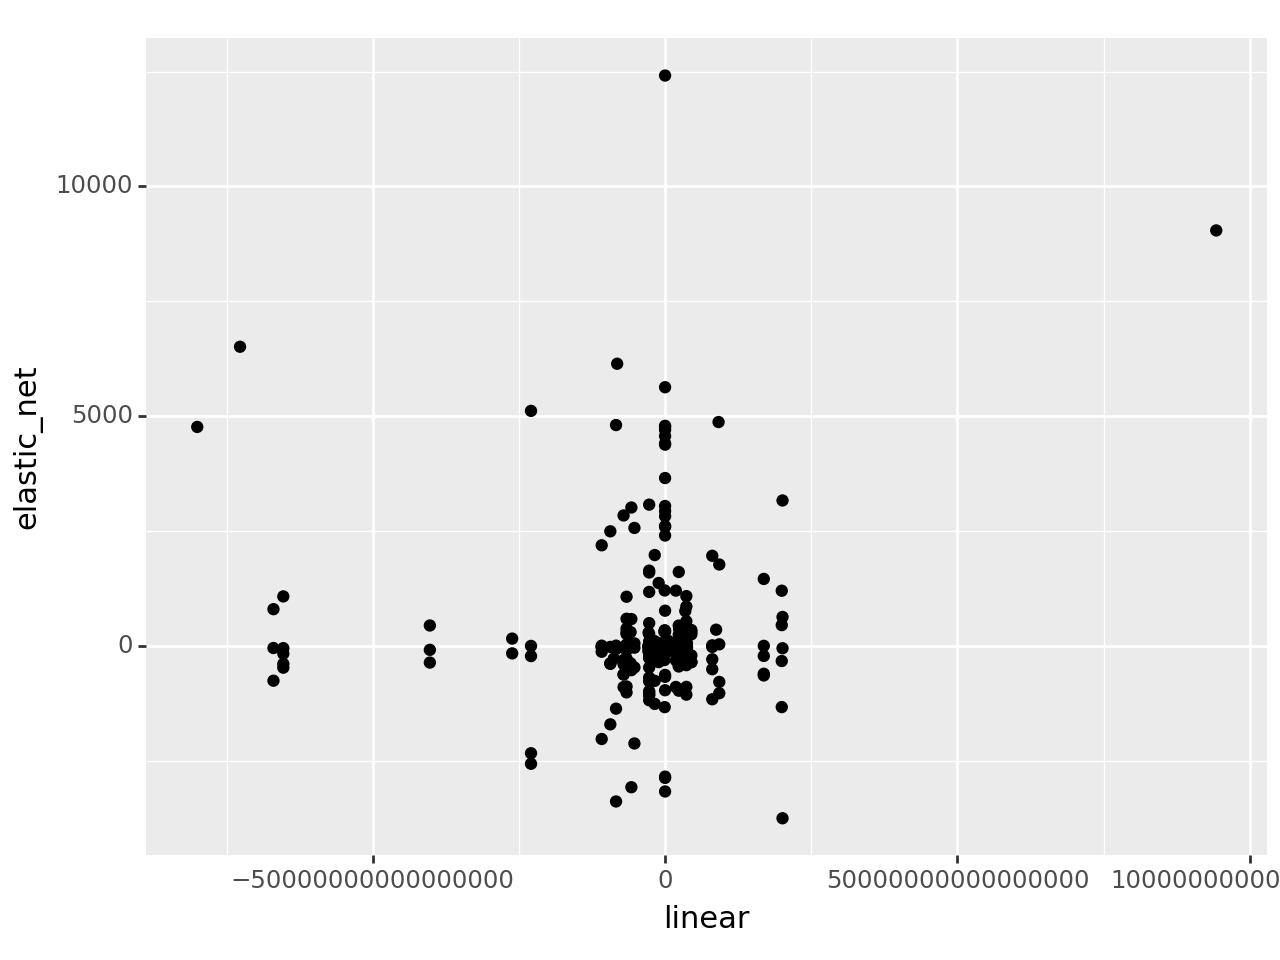

<Figure Size: (640 x 480)>

In [112]:
#compare coefficients to elastic net and ols
df_coeff["elastic_net"] = coeff_4
df_coeff

#create plot comparing coefficients to lasso and ols
(ggplot(df_coeff, aes(x = "linear", y = "elastic_net")) + geom_point())
